In [ ]:
import pandas as pd

# Load and preprocess data
simulation_data_dir = "/content/drive/MyDrive/Thesis /Data/run_angle0/export_postprocessing_U_DEM_bed_distance_1.0.csv"
terrain_data_dir = "/content/drive/MyDrive/Thesis /Data/normal_surface_bed_original.txt_cut_trim.csv"

simulation_data = pd.read_csv(simulation_data_dir)
terrain_data = pd.read_csv(terrain_data_dir)

In [ ]:
simulation_data.head()

,Point ID,Points_0,Points_1,Points_2,Points_Magnitude,U_0,U_1,U_2,U_Magnitude,k,nut,omega,p,vtkValidPointMask
0,0,-350,-50.979198,-200,406.199,21.4491,0.000000,0.000000,21.4491,0.261830,0.125500,2.05532,29.0446,1
1,1,-349,-50.981628,-200,405.338,21.1984,0.002312,-0.000291,21.1984,0.285827,0.122865,2.29545,28.9449,1
2,2,-348,-50.973942,-200,404.477,21.0610,0.004659,-0.000587,21.0610,0.308596,0.120774,2.52088,28.8444,1
3,3,-347,-50.961330,-200,403.615,21.0033,0.007074,-0.000890,21.0033,0.330625,0.119034,2.73856,28.7436,1
4,4,-346,-50.947472,-200,402.754,20.9900,0.009558,-0.001203,20.9900,0.352328,0.117471,2.95369,28.6430,1


In [ ]:
terrain_data.head()

,X,Y,Z,nx,ny,nz
0,-350.0,-50.979198,-200.0,-0.007488,0.003849,-0.999965
1,-349.0,-50.981628,-200.0,0.002628,-0.010099,-0.999946
2,-348.0,-50.973942,-200.0,0.010148,0.000729,-0.999948
3,-347.0,-50.961330,-200.0,0.013234,0.003195,-0.999907
4,-346.0,-50.947472,-200.0,0.012767,-0.015197,-0.999803


### Preprocess + duplicate (for now) for enough samples

In [ ]:
x = terrain_data.X
y = terrain_data.Y
z = terrain_data.Z

In [ ]:
import numpy as np

x_grid_len = np.sum(x == np.unique(x)[100])
z_grid_len = np.sum(z == np.unique(z)[0])
print(x_grid_len, z_grid_len)

401 701


In [ ]:
y = pd.DataFrame(y.values.reshape(x_grid_len, z_grid_len))

In [ ]:
# Shapes need to be devidable by 32
target_shape = (416, 704)

# Calculate the required padding for each dimension
pad_height = target_shape[0] - y.shape[0]
pad_width = target_shape[1] - y.shape[1]

# Pad the array
y = np.pad(y, ((0, pad_height), (0, pad_width)), mode='constant')

In [ ]:
y.shape

(416, 704)

In [ ]:
U_0 = simulation_data.loc[:, "U_0"]
U_1 = simulation_data.loc[:, "U_1"]
U_2 = simulation_data.loc[:, "U_2"]

In [ ]:
U_0 = pd.DataFrame(U_0.values.reshape(x_grid_len, z_grid_len))
U_1 = pd.DataFrame(U_1.values.reshape(x_grid_len, z_grid_len))
U_2 = pd.DataFrame(U_2.values.reshape(x_grid_len, z_grid_len))

In [ ]:
# Shapes need to be devidable by 32
target_shape = (416, 704)

# Calculate the required padding for each dimension
pad_height = target_shape[0] - U_0.shape[0]
pad_width = target_shape[1] - U_0.shape[1]

# Pad the array
U_0 = np.pad(U_0, ((0, pad_height), (0, pad_width)), mode='constant')
U_1 = np.pad(U_1, ((0, pad_height), (0, pad_width)), mode='constant')
U_2 = np.pad(U_2, ((0, pad_height), (0, pad_width)), mode='constant')

In [ ]:
U_combined_array = np.stack((U_0, U_1, U_2))

In [ ]:
U_combined_array.shape

(3, 416, 704)

## Implementation of segmentation model with 1 class and identifier last layer
this ensures a regression output

In [ ]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# change SM framework to tensorflow keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Set channels first, since the channels are the first dimension ( (1, 416, 704) for input, and (3, 416, 704) for output)
keras.backend.set_image_data_format('channels_first')

In [ ]:
# Import libraries
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [ ]:
# Define some loss and metric for training. Just picked two random one that don't neccecarily make sense.
# Did this just to check if the package is generic for the different losses and metrics.
mse = keras.metrics.MeanSquaredError()
msa_loss = keras.losses.MeanAbsoluteError()

In [ ]:
# Define the Unet model, for firs concept model I just picked the default backbone. Encoder weights to None since only 1 channel input.
# During the modelling I will test with conv layer as channel input to 3. (to utilize the weights)
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(1, None, None), classes = 3, activation = 'linear')

# Compile the model with the different loss(es) and metric(s)
model.compile('Adam', loss=msa_loss, metrics=[mse])

In [ ]:
# Save the callbacks, to later on save the model with best weights.
# Minumizing the loss so mode  = min
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# Reshape input to (1, 3, 401, 701)
y_expand = np.expand_dims(y, axis=0)
y_expand = np.expand_dims(y_expand, axis=0)
y_expand.shape

(1, 1, 416, 704)

In [ ]:
# reshape output to (1, 3, 416, 704)
U_combined_array_expand = np.expand_dims(U_combined_array, axis=0)
U_combined_array_expand.shape

(1, 3, 416, 704)

In [ ]:
# fit model
history = model.fit(
    x=y_expand,
    y=U_combined_array_expand,
    batch_size=16, # Just random batchsize, will change to larger one
    epochs=1000    # Enough epochs to see model convergence, unfortunately no validation set yet.
    #validation_data=(x_val, y_val), No validation data, for now
)

Epoch 1/1000
1/1 [==============================] - 57s 57s/step - loss: 6.2287 - mean_squared_error: 92.5811
Epoch 2/1000
1/1 [==============================] - 0s 115ms/step - loss: 6.0529 - mean_squared_error: 90.4752
Epoch 3/1000
1/1 [==============================] - 0s 115ms/step - loss: 5.9483 - mean_squared_error: 88.6476
Epoch 4/1000
1/1 [==============================] - 0s 110ms/step - loss: 5.8704 - mean_squared_error: 87.2961
Epoch 5/1000
1/1 [==============================] - 0s 102ms/step - loss: 5.8083 - mean_squared_error: 86.7335
Epoch 6/1000
1/1 [==============================] - 0s 128ms/step - loss: 5.7582 - mean_squared_error: 86.0004
Epoch 7/1000
1/1 [==============================] - 0s 107ms/step - loss: 5.7089 - mean_squared_error: 85.2723
Epoch 8/1000
1/1 [==============================] - 0s 105ms/step - loss: 5.6654 - mean_squared_error: 84.6698
Epoch 9/1000
1/1 [==============================] - 0s 104ms/step - loss: 5.6266 - mean_squared_error: 84.1275
Ep

#### Results with unadjusted Y values
- MSE metric and MSA loss function were used (just arbirary loss and metric functions, for now)
- 1000 epochs

In [ ]:
prediction = model.predict(y_expand)

1/1 [==============================] - 1s 845ms/step


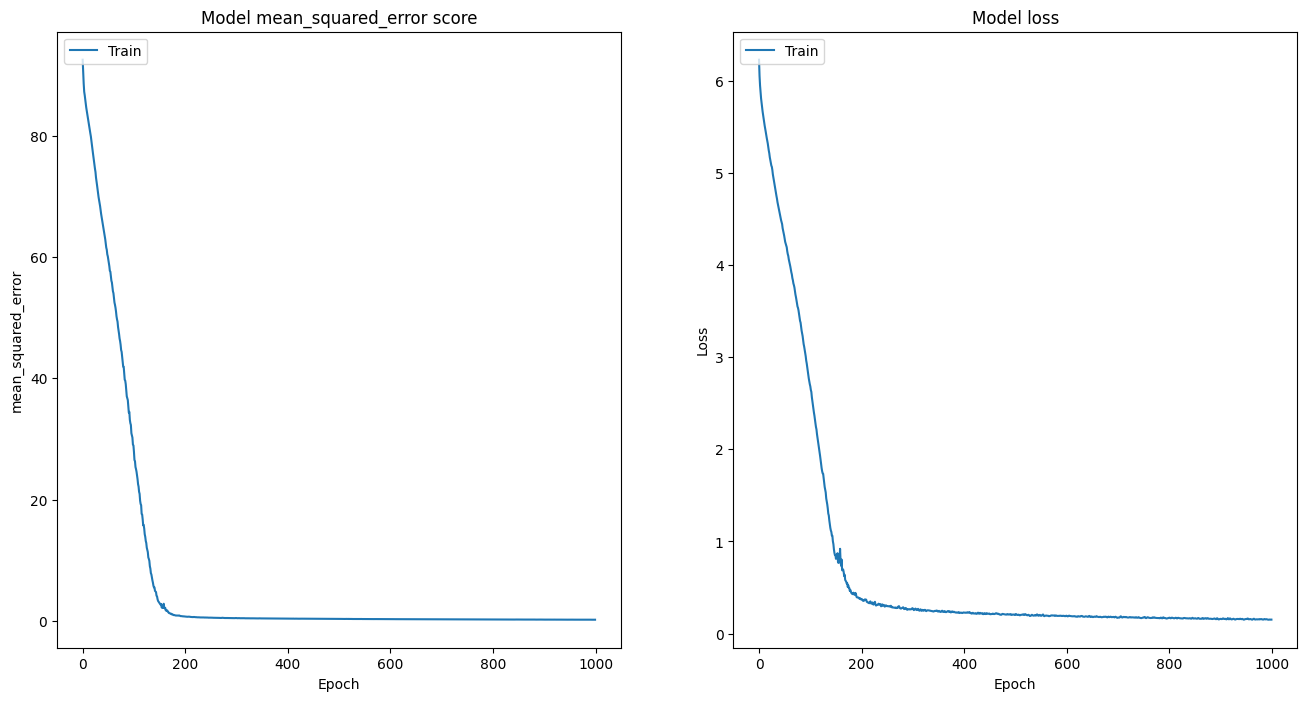

In [ ]:
# Plot Training loss and iou_score
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(history.history['mean_squared_error'])
plt.title('Model mean_squared_error score')
plt.ylabel('mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Plot the different heatmaps

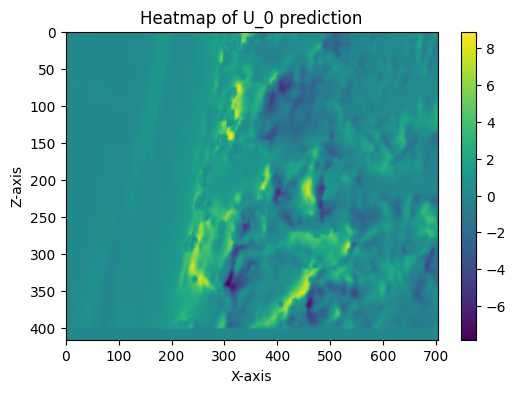

In [ ]:
plot_values = prediction[0][0]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(random_array, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_0 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

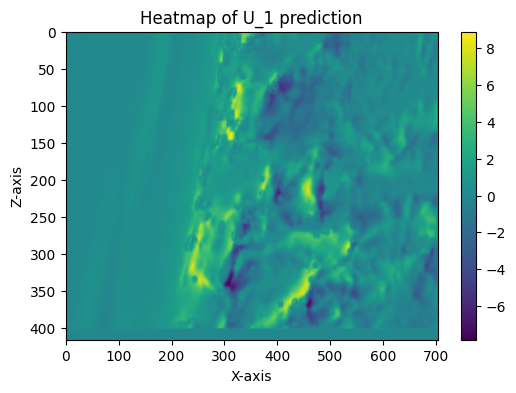

In [ ]:
plot_values = prediction[0][1]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_1 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

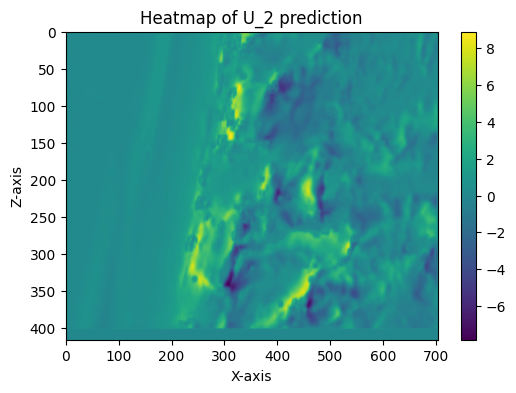

In [ ]:
plot_values = prediction[0][1]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_2 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

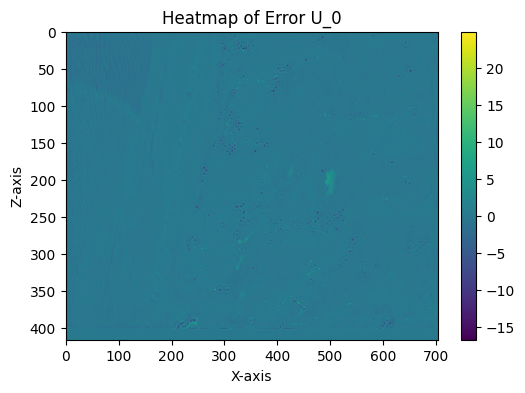

In [ ]:
plot_values = prediction[0][0] - U_combined_array_expand[0][0]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_0')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

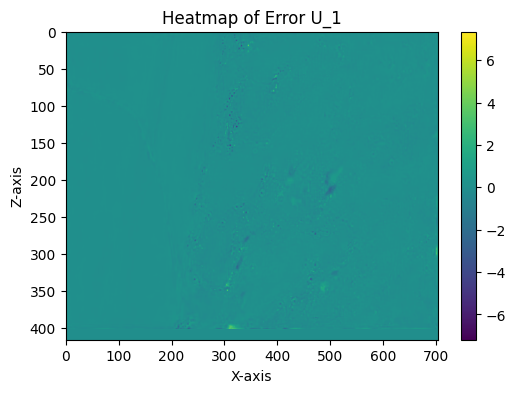

In [ ]:
plot_values = prediction[0][1] - U_combined_array_expand[0][1]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_1')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

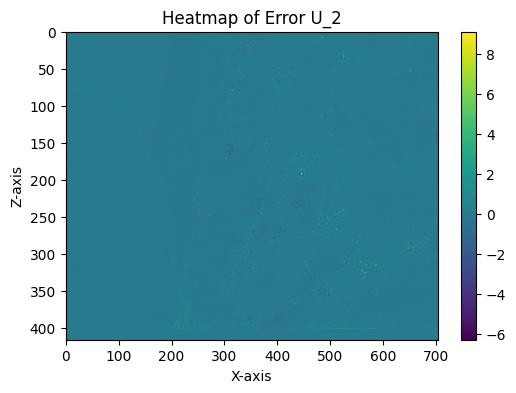

In [ ]:
plot_values = prediction[0][2] - U_combined_array_expand[0][2]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_2')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

In [ ]:
# Calculate the different RMSEs
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse_value_0 = np.sqrt(mean_squared_error(U_combined_array_expand[0][0], prediction[0][0]))
rmse_value_1 = np.sqrt(mean_squared_error(U_combined_array_expand[0][1], prediction[0][1]))
rmse_value_2 = np.sqrt(mean_squared_error(U_combined_array_expand[0][2], prediction[0][2]))
print(f"""RMSE_0: {rmse_value_0:.4f},
RMSE_1: {rmse_value_1:.4f},
RMSE_2: {rmse_value_2:.4f}
""")


RMSE_0: 0.7566,
RMSE_1: 0.1918,
RMSE_2: 0.1935



## The generated results still don't proof anything regarding model understanding and performance. Currently, the model is just very overfitted on the one input image. One could agrue that, given this fact, the RMSE is high as the model could not reproduce the same image on certain points in the map.

### A possible improvement in the model performance could be normalizing/standardizing or min/max scaling the input parameter.